# Connectome visualizer

### Some precomputations

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from ipywidgets import interact, IntSlider

def init():
    dfs = pd.read_csv('data/Neuro279_Syn.csv', index_col=0)
    dfg = pd.read_csv('data/Neuro279_EJ.csv', index_col=0)
    return dfs, dfg
    
dfs, dfg = init()
# dfg = dfg.sort_index(0)
# dfs = dfs.sort_index(1)
# dfg = dfg.sort_index(0)
# dfs = dfs.sort_index(1)
dfcat = pd.read_csv('data/neuron_categories.csv', index_col=1, header=0)
nbs = [i for i in range(len(dfs.index))]
cats = dfcat.loc[dfg.index]
motors = cats.index[cats['Category']=='MOTOR']
inters = cats.index[cats['Category']=='INTERNEURON']
sensors = cats.index[cats['Category']=='SENSORY']

### Visualization

In [2]:
""" Preferences : you can change the shape and colors of neuron categories here """
SENSOR_COLOR = '#006000'
SENSOR_SHAPE = 'o'
INTER_COLOR = '#000060'
INTER_SHAPE = 'o'
MOTOR_COLOR = '#600000'
MOTOR_SHAPE = 'o'
NODE_SIZE = 2500

style = ArrowStyle("wedge", tail_width=2., shrink_factor=0.2)
styleg = ArrowStyle("wedge", tail_width=0.6, shrink_factor=0.4)

In [3]:
@interact(neuron = sorted(dfs.index), img_size=IntSlider(min=10,max=22,step=2,value=12))
def connections(neuron='BAG', img_size=12):
    plt.figure(figsize=(img_size,img_size))
    G = nx.DiGraph()
    
    syn_in = dfs.index[dfs[neuron] > 0].tolist()
    intens_in = dfs.loc[dfs[neuron] > 0, neuron]
    syni = [(pre, neuron, {}) for pre in syn_in]
    G.add_edges_from(syni)
    
    syn_out = dfs.T.index[dfs.T[neuron] > 0].tolist()
    intens_out = dfs.T.loc[dfs.T[neuron] > 0, neuron]
    syno = [(neuron, post, {}) for post in syn_out]
    G.add_edges_from(syno)
    
    gaps_ = dfg.index[dfg[neuron] > 0].tolist()
    intens_g = 0.1*dfg.loc[dfg[neuron] > 0, neuron]
    gaps = [(neuron, k, {}) for k in gaps_] + [(k, neuron, {}) for k in gaps_]
    G.add_edges_from(gaps)
    
    G.remove_node(neuron)
    pos = nx.layout.circular_layout(G, scale=2)
    G.add_node(neuron)
    pos[neuron] = np.array([0,0])
    
    def draw_nodes(shape='o', category=inters, col='k'):
        nx.draw_networkx_nodes(G, pos, node_shape=shape, node_color=col, 
                               nodelist=[n for n in G.nodes if n in category],
                               node_size=NODE_SIZE, alpha=0.9)
    draw_nodes(SENSOR_SHAPE, sensors, SENSOR_COLOR)
    draw_nodes(INTER_SHAPE, inters, INTER_COLOR)
    draw_nodes(MOTOR_SHAPE, motors, MOTOR_COLOR)

    nx.draw_networkx_labels(G, pos, font_color='w', font_weight='bold')
    
    nx.draw_networkx_edges(G, pos, arrowstyle=style, edgelist=syni, edge_color='g',
                           arrowsize=10, alpha=0.7, width=intens_in, node_size=NODE_SIZE)
    nx.draw_networkx_edges(G, pos, arrowstyle=style, edgelist=syno, edge_color='r',
                           arrowsize=10, alpha=0.5, width=intens_out, node_size=NODE_SIZE)
    nx.draw_networkx_edges(G, pos, arrowstyle=styleg, edgelist=gaps, edge_color='Gold',
                           arrowsize=10, alpha=0.8, width=np.hstack((intens_g,intens_g)), 
                           node_size=NODE_SIZE)
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='neuron', options=('ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL', 'ADFR', …

## Plot the whole network

In [4]:
A = 'SMDDL'
B = 'SMDVL'

def select_adj(dfs, dfg):
    adjs = [A, B]
    adjs.extend(dfs.index[dfs[A] > 0])
#     adjs.extend(dfs.index[dfs.loc[A] > 0])
    adjs.extend(dfg.index[dfs[A] > 0])
#     adjs.extend(dfg.index[dfs.loc[A] > 0])
    adjs.extend(dfs.index[dfs[B] > 0])
#     adjs.extend(dfs.index[dfs.loc[B] > 0])
    adjs.extend(dfg.index[dfs[B] > 0])
#     adjs.extend(dfg.index[dfs.loc[B] > 0])
    adjs = list(set(adjs))

    dfg2 = dfg.loc[adjs, adjs]
    dfs2 = dfs.loc[adjs, adjs]
    return dfs2, dfg2

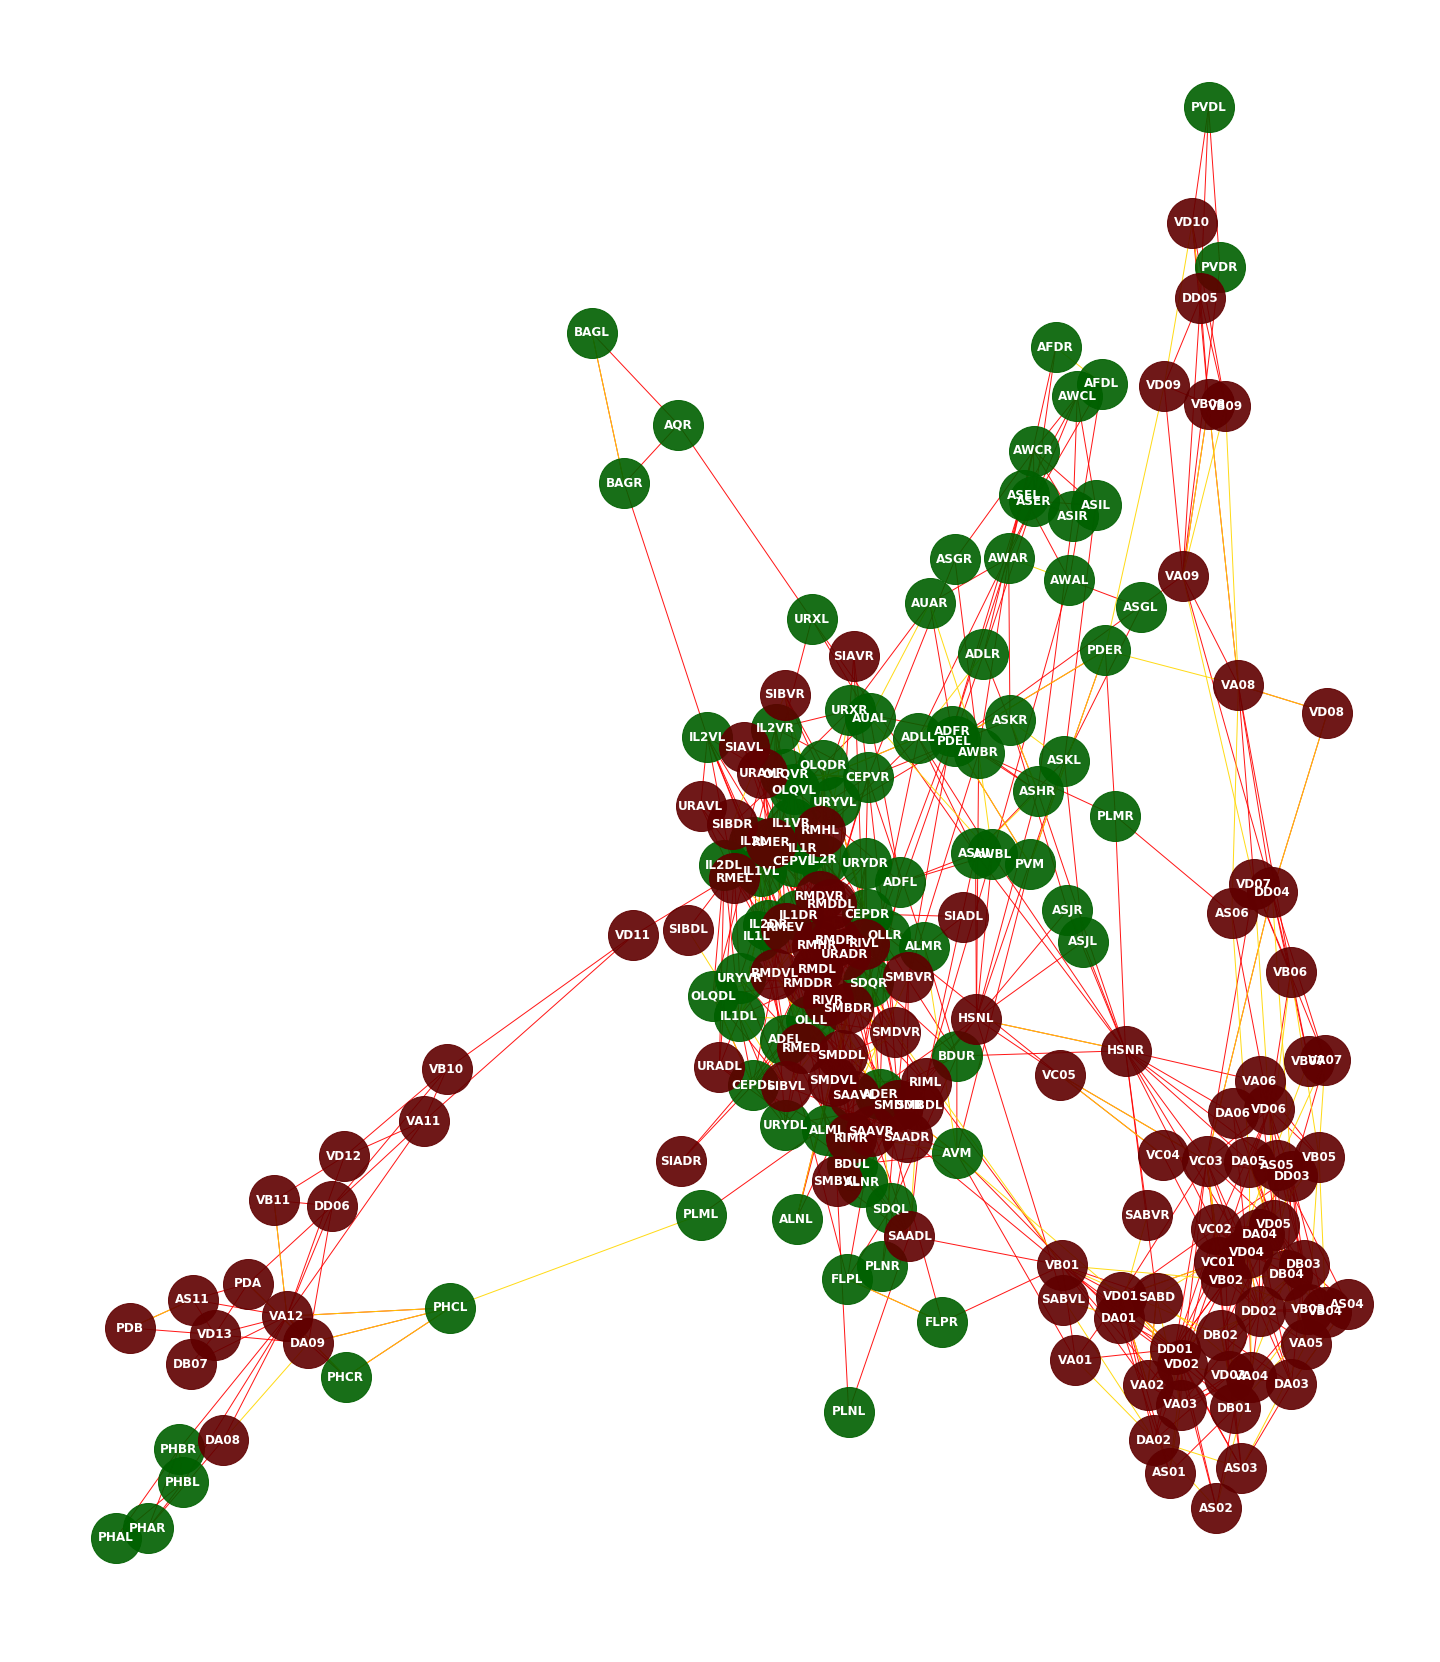

In [48]:
img_size=30
plt.figure(figsize=(25, img_size))
dfs, dfg = init()

# dfs, dfg = select_adj(dfs, dfg)
select = np.hstack((sensors, motors))
dfg = dfg.loc[select, select]
dfs = dfs.loc[select, select]

labels = {i:dfg.index[i] for i in range(dfg.shape[0])}
G1 = nx.from_numpy_matrix(dfs.values)#, create_using=nx.DiGraph())
G1 = nx.relabel.relabel_nodes(G1, labels)
G2 = nx.from_numpy_matrix(dfg.values)#, create_using=nx.DiGraph())
G2 = nx.relabel.relabel_nodes(G2, labels)

G = nx.Graph()
G.add_edges_from(G1.edges)
G.add_edges_from(G2.edges)

# rich = ['AVAL', 'AVAR', 'AVBL', 'AVBR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'PVCL', 'PVCR', 'DVA', 'AIBL', 'AIBR', 'RIAL', 'RIAR', 'RIBL', 'RIBR']
# pos = nx.layout.bipartite_layout(G, sensors)
pos = nx.layout.spring_layout(G)

def draw_nodes(shape='o', category=inters, col='k'):
        nx.draw_networkx_nodes(G, pos, node_shape=shape, node_color=col, 
                               nodelist=[n for n in G.nodes if n in category],
                               node_size=NODE_SIZE, alpha=0.9)
draw_nodes(SENSOR_SHAPE, sensors, SENSOR_COLOR)
draw_nodes(INTER_SHAPE, inters, INTER_COLOR)
draw_nodes(MOTOR_SHAPE, motors, MOTOR_COLOR)

nx.draw_networkx_edges(G, pos, edge_color='r', node_size=NODE_SIZE, arrowstyle='->', edgelist=G1.edges, 
                       alpha=0.9, width=1, arrowsize=10)
nx.draw_networkx_edges(G, pos, edge_color='Gold', node_size=NODE_SIZE, edgelist=G2.edges, 
                       alpha=0.9, width=1)

nx.draw_networkx_labels(G, pos, font_color='w', font_weight='bold')

plt.axis('off')
plt.draw()
plt.savefig('circ.png', dpi=200)